In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dropout, Dense
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import os
import time
from tensorflow.keras import backend as K
import datetime
from tensorflow.keras import metrics
import tensorflow as tf

In [ ]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

# Delete ","
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)

columns_to_clean = ['Open', 'High', 'Low', 'Close']
for col in columns_to_clean:
    train_data[col] = train_data[col].astype(str).str.replace(',', '').astype(float)
    test_data[col] = test_data[col].astype(str).str.replace(',', '').astype(float)

# Date
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

def normalize_data(data):
    data = np.array(data)
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data

train_scaled = normalize_data(train_data[['Open', 'High', 'Low', 'Close']])
test_scaled = normalize_data(test_data[['Open', 'High', 'Low', 'Close']])

# Slide window
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        y.append(data[i, 3])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, 4)
X_test, y_test = create_dataset(test_scaled, 4)

split_ratio = 0.8
split_index = int(len(X_train) * split_ratio)
X_train_final = X_train[:split_index]
y_train_final = y_train[:split_index]
X_val = X_train[split_index:]
y_val = y_train[split_index:]

print(f"Train: {X_train_final.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (1003, 4, 4), Validation: (251, 4, 4), Test: (16, 4, 4)


In [ ]:
lstm_parameters = {
    'LSTM_size': 50,
    'dropout': 0.2,
    'FC_size': 100,
    'optim': Adam,
    'lr': 0.001
}

gru_parameters = {
    'GRU_size': 50,
    'dropout': 0.2,
    'FC_size': 100,
    'optim': Adam,
    'lr': 0.001
}

rnn_parameters = {
    'RNN_size': 50,
    'dropout': 0.2,
    'FC_size': 100,
    'optim': Adam,
    'lr': 0.001
}

def build_LSTM(input_shape, parameters):
    model = Sequential()
    model.add(LSTM(units=lstm_parameters['LSTM_size'], 
                   input_shape=input_shape, 
                   unroll=True, stateful=False))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](learning_rate=parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[metrics.MeanAbsoluteError(), rmse, mda])
    return model

def build_GRU(input_shape, parameters):
    model = Sequential()
    model.add(GRU(units=gru_parameters['GRU_size'], 
                  input_shape=input_shape, 
                  unroll=True, stateful=False))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    
    optimizer = parameters["optim"](learning_rate=parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[metrics.MeanAbsoluteError(), rmse, mda])
    return model

def build_RNN(input_shape, parameters):
    model = Sequential()
    model.add(SimpleRNN(units=rnn_parameters['RNN_size'], 
                        input_shape=input_shape, 
                        unroll=True, stateful=False))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    
    optimizer = parameters["optim"](learning_rate=parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[metrics.MeanAbsoluteError(), rmse, mda])
    return model

In [5]:
def custom_callbacks(callback_list, params, filepath=None):
    callbacks = []
    
    if 'mcp' in callback_list:
        mcp = ModelCheckpoint(filepath=filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='min')
        callbacks.append(mcp)
        
    if 'csv_logger' in callback_list:
        timestamp = time.ctime().replace(" ", "_").replace(":", "_")
        csv_logger = CSVLogger(os.path.join('output', 
                                            f'training_log_{timestamp}.log'), 
                               append=True)
        callbacks.append(csv_logger)

    if 'es' in callback_list:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                           patience=params.get("earlystop", {}).get("patience", 10), 
                           min_delta=params.get("earlystop", {}).get("min_delta", 0.0001))
        callbacks.append(es)
        
    if 'reduce_lr' in callback_list:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=params.get("reduce_lr", {}).get("factor", 0.5), 
                                      patience=params.get("reduce_lr", {}).get("patience", 3),
                                      min_delta=params.get("reduce_lr", {}).get("min_delta", 0.0001),
                                      verbose=0, mode='auto', cooldown=0, min_lr=0)
        callbacks.append(reduce_lr)

    return callbacks

callback_list = ['mcp', 'csv_logger', 'es', 'reduce_lr']

In [15]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mda(y_true, y_pred, window=4):
    pred_diff = tf.sign(y_pred[window:] - y_pred[:-window])
    true_diff = tf.sign(y_true[window:] - y_true[:-window])
    return tf.reduce_mean(tf.cast(tf.equal(pred_diff, true_diff), tf.float32))

In [7]:
# LSTM
lstm_model = build_LSTM(input_shape=(None, X_train_final.shape[2]), parameters=lstm_parameters)
lstm_callbacks = custom_callbacks(callback_list, lstm_parameters, filepath='best_lstm_model.keras')
lstm_history = lstm_model.fit(X_train_final, y_train_final,
                               epochs=50,
                               batch_size=32,
                               validation_data=(X_val, y_val),
                               callbacks=lstm_callbacks,
                               verbose=1)

Epoch 1/50


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0805 - mda: 0.4994 - mean_absolute_error: 0.2134 - rmse: 0.2994
Epoch 1: val_loss improved from inf to 0.02148, saving model to best_lstm_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0637 - mda: 0.4990 - mean_absolute_error: 0.1891 - rmse: 0.2945 - val_loss: 0.0215 - val_mda: 0.5451 - val_mean_absolute_error: 0.1439 - val_rmse: 0.1474 - learning_rate: 0.0010
Epoch 2/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - mda: 0.5059 - mean_absolute_error: 0.0488 - rmse: 0.3458 
Epoch 2: val_loss improved from 0.02148 to 0.00053, saving model to best_lstm_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - mda: 0.5062 - mean_absolute_error: 0.0478 - rmse: 0.3458 - val_loss: 5.2540e-04 - val_mda: 0.5444 - val_mean_absolute_error: 0.0195 - val_rmse: 0.0372 - learning_rate: 0.0010
Epoch 3/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mda: 0.5087 - mean_absolute_error: 0.0366 - rmse: 0.3362 
Ep

Epoch 18/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mda: 0.5083 - mean_absolute_error: 0.0269 - rmse: 0.3393 
Epoch 18: val_loss did not improve from 0.00031
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mda: 0.5079 - mean_absolute_error: 0.0269 - rmse: 0.3415 - val_loss: 4.8037e-04 - val_mda: 0.5434 - val_mean_absolute_error: 0.0184 - val_rmse: 0.0379 - learning_rate: 6.2500e-05
Epoch 18: early stopping


In [8]:
# GRU
gru_model = build_GRU(input_shape=(None, X_train_final.shape[2]), parameters=gru_parameters)
gru_callbacks = custom_callbacks(callback_list, gru_parameters, filepath='best_gru_model.keras')
gru_history = gru_model.fit(X_train_final, y_train_final,
                               epochs=50,
                               batch_size=32,
                               validation_data=(X_val, y_val),
                               callbacks=gru_callbacks,
                               verbose=1)

Epoch 1/50
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1840 - mda: 0.5021 - mean_absolute_error: 0.3159 - rmse: 0.3934 
Epoch 1: val_loss improved from inf to 0.00386, saving model to best_gru_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1364 - mda: 0.5012 - mean_absolute_error: 0.2674 - rmse: 0.3517 - val_loss: 0.0039 - val_mda: 0.5389 - val_mean_absolute_error: 0.0581 - val_rmse: 0.0665 - learning_rate: 0.0010
Epoch 2/50
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - mda: 0.5068 - mean_absolute_error: 0.0675 - rmse: 0.3191 
Epoch 2: val_loss improved from 0.00386 to 0.00087, saving model to best_gru_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - mda: 0.5074 - mean_absolute_error: 0.0654 - rmse: 0.3252 - val_loss: 8.6670e-04 - val_mda: 0.5431 - val_mean_absolute_error: 0.0269 - val_rmse: 0.0431 - learning_rate: 0.0010
Epoch 3/50
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mda: 0.5075 - mean_absolute_error: 0.0414 - rmse: 

In [9]:
# RNN
rnn_model = build_RNN(input_shape=(None, X_train_final.shape[2]), parameters=rnn_parameters)
rnn_callbacks = custom_callbacks(callback_list, rnn_parameters, filepath='best_rnn_model.keras')
rnn_history = rnn_model.fit(X_train_final, y_train_final,
                               epochs=50,
                               batch_size=32,
                               validation_data=(X_val, y_val),
                               callbacks=gru_callbacks,
                               verbose=1)

Epoch 1/50
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0919 - mda: 0.5019 - mean_absolute_error: 0.2196 - rmse: 0.3423
Epoch 1: val_loss did not improve from 0.00023
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0758 - mda: 0.5019 - mean_absolute_error: 0.1932 - rmse: 0.3443 - val_loss: 0.0023 - val_mda: 0.5471 - val_mean_absolute_error: 0.0430 - val_rmse: 0.0537 - learning_rate: 0.0010
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mda: 0.5062 - mean_absolute_error: 0.0531 - rmse: 0.3560 
Epoch 2: val_loss did not improve from 0.00023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - mda: 0.5063 - mean_absolute_error: 0.0530 - rmse: 0.3553 - val_loss: 0.0089 - val_mda: 0.5475 - val_mean_absolute_error: 0.0918 - val_rmse: 0.0976 - learning_rate: 0.0010
Epoch 3/50
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mda: 0.5096 - mean_absolute_error: 0.0522 - rmse: 0.3241 
Epoch 3: val_loss did not improve from 0.00023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - mda: 0.5063 - mean_absolute_error: 0.0220 - rmse: 0.3325 - val_loss: 0.0014 - val_mda: 0.5377 - val_mean_absolute_error: 0.0344 - val_rmse: 0.0487 - learning_rate: 1.2500e-04
Epoch 19/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mda: 0.5017 - mean_absolute_error: 0.0245 - rmse: 0.3474     
Epoch 19: val_loss did not improve from 0.00023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mda: 0.5018 - mean_absolute_error: 0.0245 - rmse: 0.3462 - val_loss: 0.0023 - val_mda: 0.5357 - val_mean_absolute_error: 0.0457 - val_rmse: 0.0576 - learning_rate: 1.2500e-04
Epoch 20/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - mda: 0.5084 - mean_absolute_error: 0.0243 - rmse: 0.3505     
Epoch 20: val_loss did not improve from 0.00023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mda: 0.5085 - mean_absolute_error: 0.0243 - rmse: 0.3501 - val_loss: 0.0018 - val_mda: 0.5371 - val_mean_absolute_error: 0.039

In [ ]:
# Denormalize
def denormalize_data(normalized_data, min_vals, max_vals):
    return normalized_data * (max_vals - min_vals) + min_vals

def predict(model, X, batch_size):
    return model.predict(X, batch_size)

def calculate_mse(pred, true):
    return np.mean(np.square(pred - true))

def calculate_rmse(pred, true):
    return np.sqrt(np.mean(np.square(pred - true)))

def calculate_mda(pred, true, window=12):
    pred_diff = np.sign(pred[window:] - pred[:-window])
    true_diff = np.sign(true[window:] - true[:-window])
    return np.mean(pred_diff == true_diff)

def plot_predictions(true, pred, datetime, title=None, labels=None):
    plt.figure(figsize=(12, 6))
    plt.plot(datetime[-len(true):], true, label=labels[0], color='blue')
    plt.plot(datetime[-len(pred):], pred, label=labels[1], color='red')
    plt.title(title)
    plt.legend()
    plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


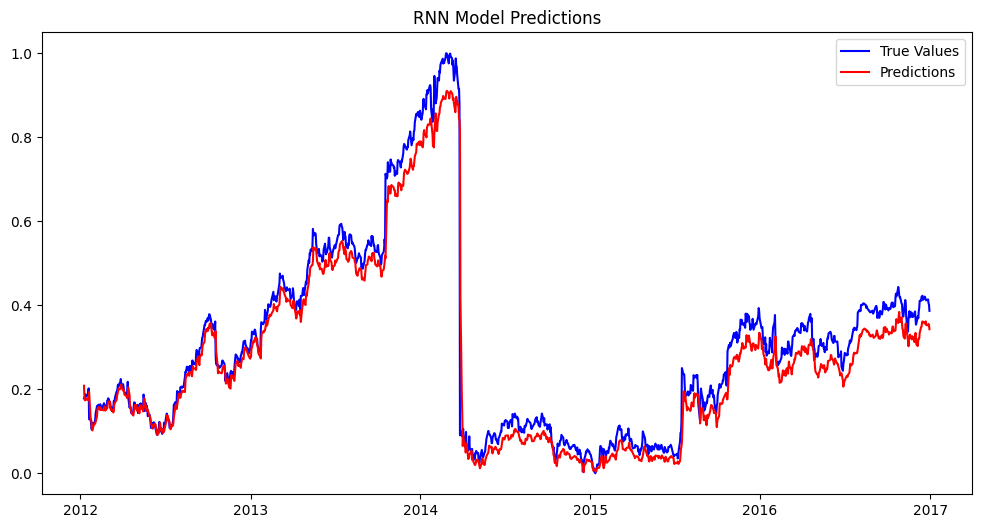

MSE: 0.09835871432045393, RMSE: 0.3136219289534039, MDA: 0.5151176871753781


In [ ]:
min_vals = np.min(y_train, axis=0)
max_vals = np.max(y_train, axis=0)

predictions = predict(rnn_model, X_train, batch_size=32)
predictions_org = denormalize_data(predictions, min_vals, max_vals)
true_org = denormalize_data(y_train, min_vals, max_vals)

mse = calculate_mse(predictions_org, true_org)
rmse = calculate_rmse(predictions_org, true_org)
mda = calculate_mda(predictions_org, true_org)

labels = ['True Values', 'Predictions']
plot_predictions(true_org, predictions_org, train_data.index, title="RNN Model Predictions", labels=labels)
print(f'MSE: {mse}, RMSE: {rmse}, MDA: {mda}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


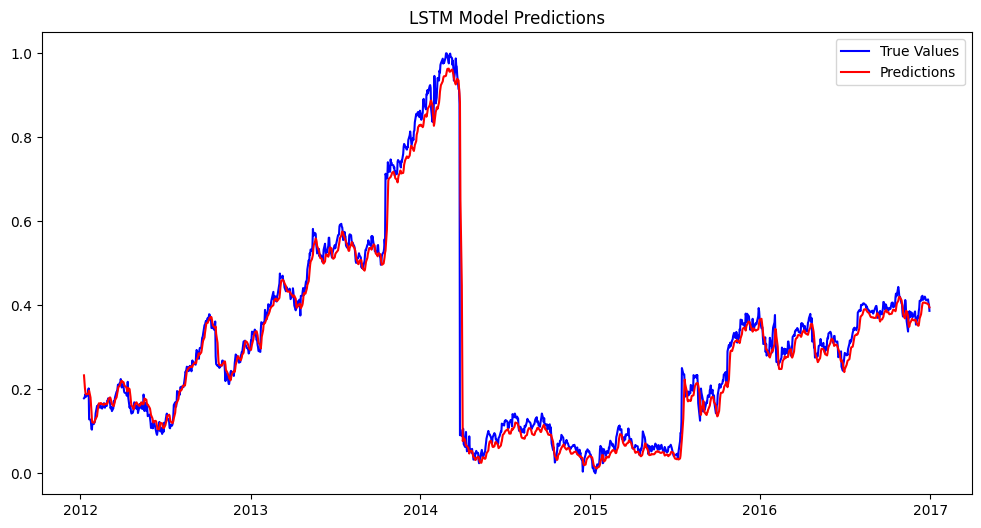

MSE: 0.1011250565409478, RMSE: 0.31800166122356627, MDA: 0.5169043229324682


In [ ]:
min_vals = np.min(y_train, axis=0)
max_vals = np.max(y_train, axis=0)

predictions = predict(lstm_model, X_train, batch_size=32)
predictions_org = denormalize_data(predictions, min_vals, max_vals)
true_org = denormalize_data(y_train, min_vals, max_vals)

mse = calculate_mse(predictions_org, true_org)
rmse = calculate_rmse(predictions_org, true_org)
mda = calculate_mda(predictions_org, true_org)

labels = ['True Values', 'Predictions']
plot_predictions(true_org, predictions_org, train_data.index, title="LSTM Model Predictions", labels=labels)
print(f'MSE: {mse}, RMSE: {rmse}, MDA: {mda}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


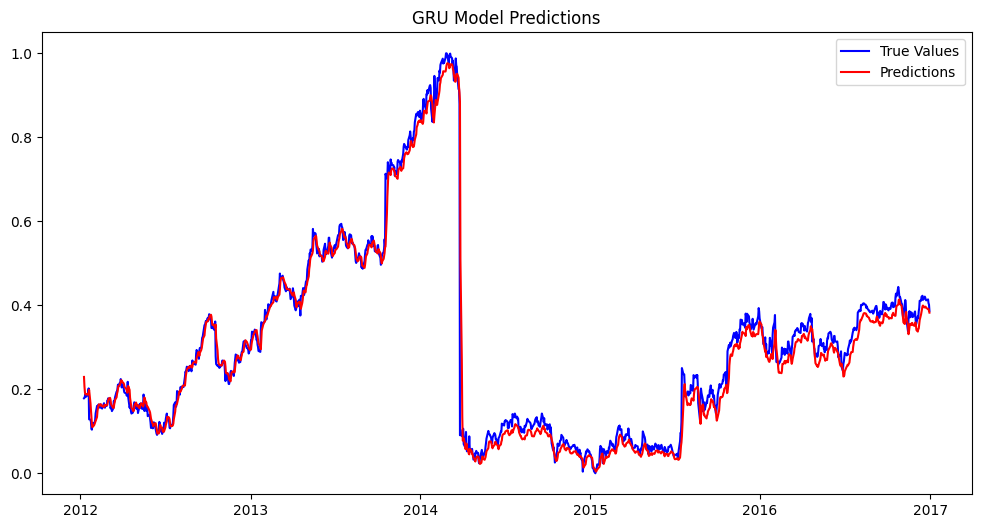

MSE: 0.10279359369274171, RMSE: 0.320614400320294, MDA: 0.5148428201358258


In [ ]:
min_vals = np.min(y_train, axis=0)
max_vals = np.max(y_train, axis=0)

predictions = predict(gru_model, X_train, batch_size=32)
predictions_org = denormalize_data(predictions, min_vals, max_vals)
true_org = denormalize_data(y_train, min_vals, max_vals)

mse = calculate_mse(predictions_org, true_org)
rmse = calculate_rmse(predictions_org, true_org)
mda = calculate_mda(predictions_org, true_org)

labels = ['True Values', 'Predictions']
plot_predictions(true_org, predictions_org, train_data.index, title="GRU Model Predictions", labels=labels)
print(f'MSE: {mse}, RMSE: {rmse}, MDA: {mda}')

In [16]:
def rnn_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    rnn_best_score = float('inf')
    rnn_best_params = {}
    RNN_sizes = [50, 100, 150]
    dropouts = [0.2, 0.3, 0.5]
    FC_sizes = [100, 150]
    lrs = [0.001, 0.01, 0.1]
    optimizers = [Adam, RMSprop, SGD]

    for RNN_size in RNN_sizes:
        for dropout in dropouts:
            for FC_size in FC_sizes:
                for lr in lrs:
                    for optim in optimizers:
                        parameters = {
                            'RNN_size': RNN_size,
                            'dropout': dropout,
                            'FC_size': FC_size,
                            'lr': lr,
                            'optim': optim
                        }
                        
                        rnn_model = build_RNN(input_shape=(None, X_train.shape[2]), parameters=parameters)
                        rnn_callbacks = custom_callbacks(callback_list, parameters, filepath='best_rnn_model.keras')
                        rnn_history = rnn_model.fit(X_train, y_train,
                                                     epochs=10,
                                                     batch_size=32,
                                                     validation_data=(X_val, y_val),
                                                     callbacks=rnn_callbacks,
                                                     verbose=0)

                        val_loss = rnn_model.evaluate(X_val, y_val, verbose=0)[0]
                        if val_loss < rnn_best_score:
                            rnn_best_score = val_loss
                            rnn_best_params = {
                                'RNN_size': RNN_size,
                                'dropout': dropout,
                                'FC_size': FC_size,
                                'lr': lr,
                                'optim': optim.__name__
                            }
    return rnn_best_params, rnn_best_score

rnn_best_params, rnn_best_score = rnn_hyperparameter_tuning(X_train_final, y_train_final, X_val, y_val)


Epoch 1: val_loss improved from inf to 0.00040, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.00040

Epoch 3: val_loss did not improve from 0.00040

Epoch 4: val_loss did not improve from 0.00040

Epoch 5: val_loss did not improve from 0.00040

Epoch 6: val_loss did not improve from 0.00040

Epoch 7: val_loss did not improve from 0.00040

Epoch 8: val_loss did not improve from 0.00040

Epoch 9: val_loss did not improve from 0.00040

Epoch 10: val_loss improved from 0.00040 to 0.00031, saving model to best_rnn_model.keras

Epoch 1: val_loss improved from inf to 0.00477, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00477 to 0.00028, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.00028

Epoch 4: val_loss did not improve from 0.00028

Epoch 5: val_loss did not improve from 0.00028

Epoch 6: val_loss did not improve from 0.00028

Epoch 7: val_loss did not improve from 0.00028

Epoch 8: val_loss did 


Epoch 1: val_loss improved from inf to 0.02735, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.02735

Epoch 3: val_loss improved from 0.02735 to 0.01917, saving model to best_rnn_model.keras

Epoch 4: val_loss improved from 0.01917 to 0.01382, saving model to best_rnn_model.keras

Epoch 5: val_loss did not improve from 0.01382

Epoch 6: val_loss improved from 0.01382 to 0.00351, saving model to best_rnn_model.keras

Epoch 7: val_loss did not improve from 0.00351

Epoch 8: val_loss did not improve from 0.00351

Epoch 9: val_loss did not improve from 0.00351

Epoch 10: val_loss did not improve from 0.00351

Epoch 1: val_loss improved from inf to 0.00511, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.00511

Epoch 3: val_loss did not improve from 0.00511

Epoch 4: val_loss improved from 0.00511 to 0.00495, saving model to best_rnn_model.keras

Epoch 5: val_loss did not improve from 0.00495

Epoch 6: val_loss improved from 0.


Epoch 8: val_loss improved from 0.00045 to 0.00033, saving model to best_rnn_model.keras

Epoch 9: val_loss did not improve from 0.00033

Epoch 10: val_loss did not improve from 0.00033

Epoch 1: val_loss improved from inf to 0.00765, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00765 to 0.00403, saving model to best_rnn_model.keras

Epoch 3: val_loss improved from 0.00403 to 0.00348, saving model to best_rnn_model.keras

Epoch 4: val_loss did not improve from 0.00348

Epoch 5: val_loss improved from 0.00348 to 0.00075, saving model to best_rnn_model.keras

Epoch 6: val_loss did not improve from 0.00075

Epoch 7: val_loss did not improve from 0.00075

Epoch 8: val_loss did not improve from 0.00075

Epoch 9: val_loss did not improve from 0.00075

Epoch 10: val_loss did not improve from 0.00075

Epoch 1: val_loss improved from inf to 0.03696, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.03696 to 0.00031, saving model to best_rnn_mode


Epoch 4: val_loss improved from 0.00438 to 0.00094, saving model to best_rnn_model.keras

Epoch 5: val_loss did not improve from 0.00094

Epoch 6: val_loss improved from 0.00094 to 0.00048, saving model to best_rnn_model.keras

Epoch 7: val_loss did not improve from 0.00048

Epoch 8: val_loss improved from 0.00048 to 0.00035, saving model to best_rnn_model.keras

Epoch 9: val_loss improved from 0.00035 to 0.00026, saving model to best_rnn_model.keras

Epoch 10: val_loss did not improve from 0.00026

Epoch 1: val_loss improved from inf to 0.03762, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.03762 to 0.02829, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.02829

Epoch 4: val_loss improved from 0.02829 to 0.00963, saving model to best_rnn_model.keras

Epoch 5: val_loss did not improve from 0.00963

Epoch 6: val_loss improved from 0.00963 to 0.00037, saving model to best_rnn_model.keras

Epoch 7: val_loss did not improve from 0.0


Epoch 1: val_loss improved from inf to 0.12439, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.12439 to 0.01333, saving model to best_rnn_model.keras

Epoch 3: val_loss improved from 0.01333 to 0.00385, saving model to best_rnn_model.keras

Epoch 4: val_loss did not improve from 0.00385

Epoch 5: val_loss did not improve from 0.00385

Epoch 6: val_loss did not improve from 0.00385

Epoch 7: val_loss did not improve from 0.00385

Epoch 8: val_loss did not improve from 0.00385

Epoch 9: val_loss did not improve from 0.00385

Epoch 10: val_loss improved from 0.00385 to 0.00253, saving model to best_rnn_model.keras

Epoch 1: val_loss improved from inf to 0.00254, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00254 to 0.00042, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.00042

Epoch 4: val_loss did not improve from 0.00042

Epoch 5: val_loss did not improve from 0.00042

Epoch 6: val_loss did not improve 


Epoch 5: val_loss improved from 0.01557 to 0.00937, saving model to best_rnn_model.keras

Epoch 6: val_loss improved from 0.00937 to 0.00706, saving model to best_rnn_model.keras

Epoch 7: val_loss improved from 0.00706 to 0.00660, saving model to best_rnn_model.keras

Epoch 8: val_loss improved from 0.00660 to 0.00634, saving model to best_rnn_model.keras

Epoch 9: val_loss did not improve from 0.00634

Epoch 10: val_loss did not improve from 0.00634

Epoch 1: val_loss improved from inf to 0.00053, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.00053

Epoch 3: val_loss did not improve from 0.00053

Epoch 4: val_loss did not improve from 0.00053

Epoch 5: val_loss improved from 0.00053 to 0.00031, saving model to best_rnn_model.keras

Epoch 6: val_loss improved from 0.00031 to 0.00023, saving model to best_rnn_model.keras

Epoch 7: val_loss did not improve from 0.00023

Epoch 8: val_loss did not improve from 0.00023

Epoch 9: val_loss did not improve fr


Epoch 4: val_loss improved from 0.00610 to 0.00507, saving model to best_rnn_model.keras

Epoch 5: val_loss improved from 0.00507 to 0.00504, saving model to best_rnn_model.keras

Epoch 6: val_loss did not improve from 0.00504

Epoch 7: val_loss improved from 0.00504 to 0.00490, saving model to best_rnn_model.keras

Epoch 8: val_loss improved from 0.00490 to 0.00482, saving model to best_rnn_model.keras

Epoch 9: val_loss did not improve from 0.00482

Epoch 10: val_loss did not improve from 0.00482

Epoch 1: val_loss improved from inf to 0.00226, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.00226

Epoch 3: val_loss did not improve from 0.00226

Epoch 4: val_loss did not improve from 0.00226

Epoch 5: val_loss did not improve from 0.00226

Epoch 6: val_loss did not improve from 0.00226

Epoch 7: val_loss did not improve from 0.00226

Epoch 8: val_loss did not improve from 0.00226

Epoch 9: val_loss did not improve from 0.00226

Epoch 10: val_loss did n


Epoch 9: val_loss did not improve from 0.00101

Epoch 10: val_loss did not improve from 0.00101

Epoch 1: val_loss improved from inf to 0.23799, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.23799 to 0.09703, saving model to best_rnn_model.keras

Epoch 3: val_loss improved from 0.09703 to 0.05530, saving model to best_rnn_model.keras

Epoch 4: val_loss improved from 0.05530 to 0.04337, saving model to best_rnn_model.keras

Epoch 5: val_loss improved from 0.04337 to 0.03434, saving model to best_rnn_model.keras

Epoch 6: val_loss improved from 0.03434 to 0.03348, saving model to best_rnn_model.keras

Epoch 7: val_loss did not improve from 0.03348

Epoch 8: val_loss did not improve from 0.03348

Epoch 9: val_loss did not improve from 0.03348

Epoch 10: val_loss did not improve from 0.03348

Epoch 1: val_loss improved from inf to 0.03821, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.03821 to 0.01662, saving model to best_rnn_model.kera


Epoch 8: val_loss did not improve from 0.00035

Epoch 9: val_loss did not improve from 0.00035

Epoch 10: val_loss did not improve from 0.00035

Epoch 1: val_loss improved from inf to 0.87692, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.87692 to 0.12304, saving model to best_rnn_model.keras

Epoch 3: val_loss improved from 0.12304 to 0.02835, saving model to best_rnn_model.keras

Epoch 4: val_loss improved from 0.02835 to 0.00553, saving model to best_rnn_model.keras

Epoch 5: val_loss did not improve from 0.00553

Epoch 6: val_loss did not improve from 0.00553

Epoch 7: val_loss did not improve from 0.00553

Epoch 8: val_loss did not improve from 0.00553

Epoch 9: val_loss improved from 0.00553 to 0.00440, saving model to best_rnn_model.keras

Epoch 10: val_loss did not improve from 0.00440

Epoch 1: val_loss improved from inf to 0.07147, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.07147

Epoch 3: val_loss improved from 0


Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 1: val_loss improved from inf to 0.00316, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00316 to 0.00279, saving model to best_rnn_model.keras

Epoch 3: val_loss improved from 0.00279 to 0.00023, saving model to best_rnn_model.keras

Epoch 4: val_loss did not improve from 0.00023

Epoch 5: val_loss did not improve from 0.00023

Epoch 6: val_loss did not improve from 0.00023

Epoch 7: val_loss did not improve from 0.00023

Epoch 8: val_loss did not improve from 0.00023

Epoch 9: val_loss did not improve from 0.00023

Epoch 10: val_loss did not improve from 0.00023

Epoch 1: val_loss improved from inf to 0.00854, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00854 to 0.00155, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.00155

Epoch 4: val_loss did not i


Epoch 5: val_loss did not improve from 0.00059

Epoch 6: val_loss did not improve from 0.00059

Epoch 7: val_loss did not improve from 0.00059

Epoch 8: val_loss improved from 0.00059 to 0.00039, saving model to best_rnn_model.keras

Epoch 9: val_loss improved from 0.00039 to 0.00029, saving model to best_rnn_model.keras

Epoch 10: val_loss did not improve from 0.00029

Epoch 1: val_loss improved from inf to 0.01760, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.01760 to 0.00318, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.00318

Epoch 4: val_loss improved from 0.00318 to 0.00079, saving model to best_rnn_model.keras

Epoch 5: val_loss did not improve from 0.00079

Epoch 6: val_loss did not improve from 0.00079

Epoch 7: val_loss did not improve from 0.00079

Epoch 8: val_loss improved from 0.00079 to 0.00064, saving model to best_rnn_model.keras

Epoch 9: val_loss did not improve from 0.00064

Epoch 10: val_loss did not imp


Epoch 10: val_loss did not improve from 0.00226

Epoch 1: val_loss improved from inf to 0.00620, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.00620

Epoch 3: val_loss did not improve from 0.00620

Epoch 4: val_loss improved from 0.00620 to 0.00565, saving model to best_rnn_model.keras

Epoch 5: val_loss improved from 0.00565 to 0.00327, saving model to best_rnn_model.keras

Epoch 6: val_loss did not improve from 0.00327

Epoch 7: val_loss improved from 0.00327 to 0.00022, saving model to best_rnn_model.keras

Epoch 8: val_loss did not improve from 0.00022

Epoch 9: val_loss did not improve from 0.00022

Epoch 10: val_loss did not improve from 0.00022

Epoch 1: val_loss improved from inf to 0.00320, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.00320

Epoch 3: val_loss did not improve from 0.00320

Epoch 4: val_loss did not improve from 0.00320

Epoch 5: val_loss did not improve from 0.00320

Epoch 6: val_loss did not i


Epoch 6: val_loss did not improve from 0.00090

Epoch 7: val_loss did not improve from 0.00090

Epoch 8: val_loss did not improve from 0.00090

Epoch 9: val_loss improved from 0.00090 to 0.00044, saving model to best_rnn_model.keras

Epoch 10: val_loss did not improve from 0.00044

Epoch 1: val_loss improved from inf to 0.00212, saving model to best_rnn_model.keras

Epoch 2: val_loss did not improve from 0.00212

Epoch 3: val_loss did not improve from 0.00212

Epoch 4: val_loss did not improve from 0.00212

Epoch 5: val_loss did not improve from 0.00212

Epoch 6: val_loss improved from 0.00212 to 0.00091, saving model to best_rnn_model.keras

Epoch 7: val_loss did not improve from 0.00091

Epoch 8: val_loss did not improve from 0.00091

Epoch 9: val_loss improved from 0.00091 to 0.00037, saving model to best_rnn_model.keras

Epoch 10: val_loss did not improve from 0.00037

Epoch 1: val_loss improved from inf to 0.01498, saving model to best_rnn_model.keras

Epoch 2: val_loss improved 

In [17]:
def gru_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    gru_best_score = float('inf')
    gru_best_params = {}
    GRU_sizes = [50, 100, 150]
    dropouts = [0.2, 0.3, 0.5]
    FC_sizes = [100, 150]
    lrs = [0.001, 0.01, 0.1]
    optimizers = [Adam, RMSprop, SGD]

    for GRU_size in GRU_sizes:
        for dropout in dropouts:
            for FC_size in FC_sizes:
                for lr in lrs:
                    for optim in optimizers:
                        parameters = {
                            'GRU_size': GRU_size,
                            'dropout': dropout,
                            'FC_size': FC_size,
                            'lr': lr,
                            'optim': optim
                        }
                        
                        gru_model = build_GRU(input_shape=(None, X_train.shape[2]), parameters=parameters)
                        gru_callbacks = custom_callbacks(callback_list, parameters, filepath='best_gru_model.keras')
                        gru_history = gru_model.fit(X_train, y_train,
                                                     epochs=10,
                                                     batch_size=32,
                                                     validation_data=(X_val, y_val),
                                                     callbacks=rnn_callbacks,
                                                     verbose=0)

                        val_loss = gru_model.evaluate(X_val, y_val, verbose=0)[0]
                        if val_loss < gru_best_score:
                            gru_best_score = val_loss
                            gru_best_params = {
                                'GRU_size': GRU_size,
                                'dropout': dropout,
                                'FC_size': FC_size,
                                'lr': lr,
                                'optim': optim.__name__
                            }
    return gru_best_params, gru_best_score

gru_best_params, gru_best_score = gru_hyperparameter_tuning(X_train_final, y_train_final, X_val, y_val)


Epoch 1: val_loss improved from inf to 0.00127, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00127 to 0.00025, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 


Epoch 8: val_loss did not improve from 0.00021

Epoch 9: val_loss did not improve from 0.00021

Epoch 10: val_loss did not improve from 0.00021

Epoch 1: val_loss did not improve from 0.00021

Epoch 2: val_loss did not improve from 0.00021

Epoch 3: val_loss did not improve from 0.00021

Epoch 4: val_loss did not improve from 0.00021

Epoch 5: val_loss did not improve from 0.00021

Epoch 6: val_loss did not improve from 0.00021

Epoch 7: val_loss did not improve from 0.00021

Epoch 8: val_loss did not improve from 0.00021

Epoch 9: val_loss did not improve from 0.00021

Epoch 10: val_loss did not improve from 0.00021

Epoch 1: val_loss did not improve from 0.00021

Epoch 2: val_loss did not improve from 0.00021

Epoch 3: val_loss did not improve from 0.00021

Epoch 4: val_loss did not improve from 0.00021

Epoch 5: val_loss did not improve from 0.00021

Epoch 6: val_loss did not improve from 0.00021

Epoch 7: val_loss did not improve from 0.00021

Epoch 8: val_loss did not improve fro


Epoch 9: val_loss did not improve from 0.00021

Epoch 10: val_loss did not improve from 0.00021

Epoch 1: val_loss did not improve from 0.00021

Epoch 2: val_loss did not improve from 0.00021

Epoch 3: val_loss did not improve from 0.00021

Epoch 4: val_loss did not improve from 0.00021

Epoch 5: val_loss did not improve from 0.00021

Epoch 6: val_loss did not improve from 0.00021

Epoch 7: val_loss did not improve from 0.00021

Epoch 8: val_loss did not improve from 0.00021

Epoch 9: val_loss did not improve from 0.00021

Epoch 10: val_loss did not improve from 0.00021

Epoch 1: val_loss did not improve from 0.00021

Epoch 2: val_loss did not improve from 0.00021

Epoch 3: val_loss did not improve from 0.00021

Epoch 4: val_loss did not improve from 0.00021

Epoch 5: val_loss did not improve from 0.00021

Epoch 6: val_loss did not improve from 0.00021

Epoch 7: val_loss did not improve from 0.00021

Epoch 8: val_loss did not improve from 0.00021

Epoch 9: val_loss did not improve fro


Epoch 10: val_loss did not improve from 0.00021

Epoch 1: val_loss did not improve from 0.00021

Epoch 2: val_loss did not improve from 0.00021

Epoch 3: val_loss did not improve from 0.00021

Epoch 4: val_loss did not improve from 0.00021

Epoch 5: val_loss did not improve from 0.00021

Epoch 6: val_loss did not improve from 0.00021

Epoch 7: val_loss did not improve from 0.00021

Epoch 8: val_loss did not improve from 0.00021

Epoch 9: val_loss did not improve from 0.00021

Epoch 10: val_loss did not improve from 0.00021

Epoch 1: val_loss did not improve from 0.00021

Epoch 2: val_loss did not improve from 0.00021

Epoch 3: val_loss did not improve from 0.00021

Epoch 4: val_loss did not improve from 0.00021

Epoch 5: val_loss did not improve from 0.00021

Epoch 6: val_loss did not improve from 0.00021

Epoch 7: val_loss did not improve from 0.00021

Epoch 8: val_loss did not improve from 0.00021

Epoch 9: val_loss did not improve from 0.00021

Epoch 10: val_loss did not improve fr


Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve fro


Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve fr


Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve fro


Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve fro


Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve fro


Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve fro

In [18]:
def lstm_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    lstm_best_score = float('inf')
    letm_best_params = {}
    LSTM_sizes = [50, 100, 150]
    dropouts = [0.2, 0.3, 0.5]
    FC_sizes = [100, 150]
    lrs = [0.001, 0.01, 0.1]
    optimizers = [Adam, RMSprop, SGD]

    for LSTM_size in LSTM_sizes:
        for dropout in dropouts:
            for FC_size in FC_sizes:
                for lr in lrs:
                    for optim in optimizers:
                        parameters = {
                            'LSTM_size': LSTM_size,
                            'dropout': dropout,
                            'FC_size': FC_size,
                            'lr': lr,
                            'optim': optim
                        }
                        
                        lstm_model = build_LSTM(input_shape=(None, X_train.shape[2]), parameters=parameters)
                        lstm_callbacks = custom_callbacks(callback_list, parameters, filepath='best_lstm_model.keras')
                        lstm_history = lstm_model.fit(X_train, y_train,
                                                     epochs=10,
                                                     batch_size=32,
                                                     validation_data=(X_val, y_val),
                                                     callbacks=rnn_callbacks,
                                                     verbose=0)

                        val_loss = lstm_model.evaluate(X_val, y_val, verbose=0)[0]
                        if val_loss < lstm_best_score:
                            lstm_best_score = val_loss
                            lstm_best_params = {
                                'LSTM_size': LSTM_size,
                                'dropout': dropout,
                                'FC_size': FC_size,
                                'lr': lr,
                                'optim': optim.__name__
                            }
    return lstm_best_params, lstm_best_score

lstm_best_params, lstm_best_score = lstm_hyperparameter_tuning(X_train_final, y_train_final, X_val, y_val)


Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve fro


Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve fro


Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve fro


Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve fro


Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve fro


Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve fro


Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve fro


Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve fro


Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve fro


Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve from 0.00018

Epoch 1: val_loss did not improve from 0.00018

Epoch 2: val_loss did not improve from 0.00018

Epoch 3: val_loss did not improve from 0.00018

Epoch 4: val_loss did not improve from 0.00018

Epoch 5: val_loss did not improve from 0.00018

Epoch 6: val_loss did not improve from 0.00018

Epoch 7: val_loss did not improve from 0.00018

Epoch 8: val_loss did not improve from 0.00018

Epoch 9: val_loss did not improve from 0.00018

Epoch 10: val_loss did not improve fr

In [19]:
print(f"Best parameters: {rnn_best_params}")
print(f"Best parameters: {gru_best_params}")
print(f"Best parameters: {lstm_best_params}")

Best parameters: {'RNN_size': 150, 'dropout': 0.2, 'FC_size': 100, 'lr': 0.01, 'optim': 'RMSprop'}
Best parameters: {'GRU_size': 150, 'dropout': 0.3, 'FC_size': 100, 'lr': 0.01, 'optim': 'Adam'}
Best parameters: {'LSTM_size': 50, 'dropout': 0.2, 'FC_size': 150, 'lr': 0.01, 'optim': 'RMSprop'}


In [20]:
optimizer_mapping = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

if isinstance(lstm_best_params["optim"], str):
    lstm_best_params["optim"] = optimizer_mapping[lstm_best_params["optim"]]

lstm_final_model = build_LSTM(input_shape=(None, X_train_final.shape[2]), parameters=lstm_best_params)
lstm_final_callbacks = custom_callbacks(callback_list, lstm_best_params, filepath='lstm_final_model.keras')

lstm_final_history = lstm_final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=lstm_final_callbacks,
    verbose=1
)

lstm_test_loss, lstm_test_mae, lstm_test_rmse, lstm_test_mda = lstm_final_model.evaluate(X_test, y_test, verbose=1)
print("\nFinal Model Evaluation on Test Set:")
print(f"Loss (MSE): {lstm_test_loss}")
print(f"MAE: {lstm_test_mae}")
print(f"RMSE: {lstm_test_rmse}")
print(f"MDA: {lstm_test_mda}")

Epoch 1/50
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1333 - mda: 0.5017 - mean_absolute_error: 0.2680 - rmse: 0.3784
Epoch 1: val_loss improved from inf to 0.00168, saving model to lstm_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1110 - mda: 0.5031 - mean_absolute_error: 0.2371 - rmse: 0.3663 - val_loss: 0.0017 - val_mda: 0.5431 - val_mean_absolute_error: 0.0374 - val_rmse: 0.0528 - learning_rate: 0.0100
Epoch 2/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mda: 0.5080 - mean_absolute_error: 0.0832 - rmse: 0.3569 
Epoch 2: val_loss did not improve from 0.00168
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - mda: 0.5076 - mean_absolute_error: 0.0814 - rmse: 0.3529 - val_loss: 0.0383 - val_mda: 0.5380 - val_mean_absolute_error: 0.1927 - val_rmse: 0.1953 - learning_rate: 0.0100
Epoch 3/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - mda: 0.5045 - mean_absolute_error: 0.0786 - rmse: 0.3327 
Epoch 3: val_loss did not improve fro

Epoch 18/50
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - mda: 0.5043 - mean_absolute_error: 0.0267 - rmse: 0.3462 
Epoch 18: val_loss improved from 0.00035 to 0.00023, saving model to lstm_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - mda: 0.5041 - mean_absolute_error: 0.0252 - rmse: 0.3454 - val_loss: 2.3195e-04 - val_mda: 0.5386 - val_mean_absolute_error: 0.0112 - val_rmse: 0.0350 - learning_rate: 6.2500e-04
Epoch 19/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - mda: 0.5024 - mean_absolute_error: 0.0228 - rmse: 0.3628 
Epoch 19: val_loss did not improve from 0.00023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mda: 0.5030 - mean_absolute_error: 0.0224 - rmse: 0.3608 - val_loss: 3.5049e-04 - val_mda: 0.5386 - val_mean_absolute_error: 0.0147 - val_rmse: 0.0372 - learning_rate: 6.2500e-04
Epoch 20/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mda: 0.5116 - mean_absolute_error: 0.0213 - rmse: 0.3445 
Epoch 20: va

In [21]:
optimizer_mapping = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

if isinstance(gru_best_params["optim"], str):
    gru_best_params["optim"] = optimizer_mapping[gru_best_params["optim"]]

gru_final_model = build_LSTM(input_shape=(None, X_train_final.shape[2]), parameters=gru_best_params)
gru_final_callbacks = custom_callbacks(callback_list, gru_best_params, filepath='gru_final_model.keras')

gru_final_history = gru_final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=gru_final_callbacks,
    verbose=1
)

gru_test_loss, gru_test_mae, gru_test_rmse, gru_test_mda = gru_final_model.evaluate(X_test, y_test, verbose=1)
print("\nFinal Model Evaluation on Test Set:")
print(f"Loss (MSE): {gru_test_loss}")
print(f"MAE: {gru_test_mae}")
print(f"RMSE: {gru_test_rmse}")
print(f"MDA: {gru_test_mda}")

Epoch 1/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432 - mda: 0.5018 - mean_absolute_error: 0.1347 - rmse: 0.3153 
Epoch 1: val_loss improved from inf to 0.00130, saving model to gru_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0373 - mda: 0.5022 - mean_absolute_error: 0.1236 - rmse: 0.3208 - val_loss: 0.0013 - val_mda: 0.5428 - val_mean_absolute_error: 0.0331 - val_rmse: 0.0471 - learning_rate: 0.0100
Epoch 2/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mda: 0.5061 - mean_absolute_error: 0.0511 - rmse: 0.3403 
Epoch 2: val_loss improved from 0.00130 to 0.00043, saving model to gru_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - mda: 0.5062 - mean_absolute_error: 0.0496 - rmse: 0.3408 - val_loss: 4.2816e-04 - val_mda: 0.5428 - val_mean_absolute_error: 0.0175 - val_rmse: 0.0366 - learning_rate: 0.0100
Epoch 3/50
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mda: 0.5041 - mean_absolute_error: 0.0325 - rmse

Epoch 18/50
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mda: 0.5091 - mean_absolute_error: 0.0260 - rmse: 0.3412 
Epoch 18: val_loss did not improve from 0.00022
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mda: 0.5092 - mean_absolute_error: 0.0260 - rmse: 0.3420 - val_loss: 2.2196e-04 - val_mda: 0.5386 - val_mean_absolute_error: 0.0108 - val_rmse: 0.0343 - learning_rate: 0.0012
Epoch 19/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mda: 0.5069 - mean_absolute_error: 0.0215 - rmse: 0.3371     
Epoch 19: val_loss did not improve from 0.00022
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - mda: 0.5066 - mean_absolute_error: 0.0216 - rmse: 0.3380 - val_loss: 5.9320e-04 - val_mda: 0.5389 - val_mean_absolute_error: 0.0216 - val_rmse: 0.0397 - learning_rate: 6.2500e-04
Epoch 20/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mda: 0.5048 - mean_absolute_error: 0.0228 - rmse: 0.3680 
Epoch 20: val_loss did not improve from 0.00022
32/32 ━━

In [22]:
optimizer_mapping = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

if isinstance(rnn_best_params["optim"], str):
    rnn_best_params["optim"] = optimizer_mapping[rnn_best_params["optim"]]

rnn_final_model = build_RNN(input_shape=(None, X_train_final.shape[2]), parameters=rnn_best_params)
rnn_final_callbacks = custom_callbacks(callback_list, rnn_best_params, filepath='rnn_final_model.keras')

rnn_final_history = rnn_final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=rnn_final_callbacks,
    verbose=1
)

rnn_test_loss, rnn_test_mae, rnn_test_rmse, rnn_test_mda = rnn_final_model.evaluate(X_test, y_test, verbose=1)
print("\nFinal Model Evaluation on Test Set:")
print(f"Loss (MSE): {rnn_test_loss}")
print(f"MAE: {rnn_test_mae}")
print(f"RMSE: {rnn_test_rmse}")
print(f"MDA: {rnn_test_mda}")

Epoch 1/50
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3329 - mda: 0.5049 - mean_absolute_error: 0.6329 - rmse: 0.7668   
Epoch 1: val_loss improved from inf to 0.01563, saving model to rnn_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1065 - mda: 0.5047 - mean_absolute_error: 0.5394 - rmse: 0.6924 - val_loss: 0.0156 - val_mda: 0.5477 - val_mean_absolute_error: 0.1237 - val_rmse: 0.1285 - learning_rate: 0.0100
Epoch 2/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0227 - mda: 0.5026 - mean_absolute_error: 0.1346 - rmse: 0.4014
Epoch 2: val_loss improved from 0.01563 to 0.00345, saving model to rnn_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 - mda: 0.5032 - mean_absolute_error: 0.1272 - rmse: 0.3574 - val_loss: 0.0035 - val_mda: 0.5431 - val_mean_absolute_error: 0.0557 - val_rmse: 0.0654 - learning_rate: 0.0100
Epoch 3/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0085 - mda: 0.5026 - mean_absolute_error: 0.0798 - rmse:

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2224e-04 - mda: 0.5000 - mean_absolute_error: 0.0209 - rmse: 0.2515
Epoch 18: val_loss did not improve from 0.00020
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8130e-04 - mda: 0.5033 - mean_absolute_error: 0.0203 - rmse: 0.3413 - val_loss: 9.8986e-04 - val_mda: 0.5384 - val_mean_absolute_error: 0.0284 - val_rmse: 0.0471 - learning_rate: 0.0025
Epoch 19/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.5073e-04 - mda: 0.5000 - mean_absolute_error: 0.0217 - rmse: 0.3785
Epoch 19: val_loss did not improve from 0.00020
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mda: 0.5085 - mean_absolute_error: 0.0198 - rmse: 0.3613 - val_loss: 0.0022 - val_mda: 0.5362 - val_mean_absolute_error: 0.0442 - val_rmse: 0.0586 - learning_rate: 0.0012
Epoch 20/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016 - mda: 0.5408 - mean_absolute_error: 0.0296 - rmse: 0.3917
Epoch 20: val_loss improved from 0.00020 to 0.00019, saving model to

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


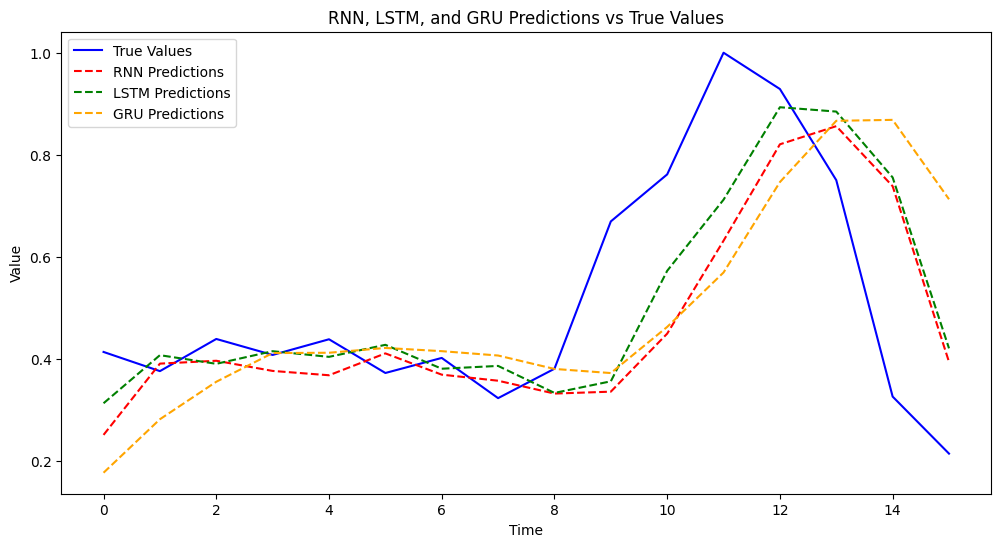

In [ ]:
rnn_predictions = predict(rnn_model, X_test, batch_size=32)
lstm_predictions = predict(lstm_final_model, X_test, batch_size=32)
gru_predictions = predict(gru_final_model, X_test, batch_size=32)

# Rescale values
rnn_predictions_org = denormalize_data(rnn_predictions, min_vals, max_vals)
lstm_predictions_org = denormalize_data(lstm_predictions, min_vals, max_vals)
gru_predictions_org = denormalize_data(gru_predictions, min_vals, max_vals)
true_org = denormalize_data(y_test, min_vals, max_vals)

plt.figure(figsize=(12, 6))
plt.plot(true_org, label='True Values', color='blue')
plt.plot(rnn_predictions_org, label='RNN Predictions', color='red', linestyle='--')
plt.plot(lstm_predictions_org, label='LSTM Predictions', color='green', linestyle='--')
plt.plot(gru_predictions_org, label='GRU Predictions', color='orange', linestyle='--')

plt.title('RNN, LSTM, and GRU Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\12902\AppData\Local\Temp\ipykernel_2932\676563345.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]  # Only 'Close' column (index 3)
C:\Users\12902\AppData\Local\Temp\ipykernel_2932\676563345.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]  # Only 'Close' column (index 3)
C:\Users\12902\AppData\Local\Temp\ipykernel_2932\676563345.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

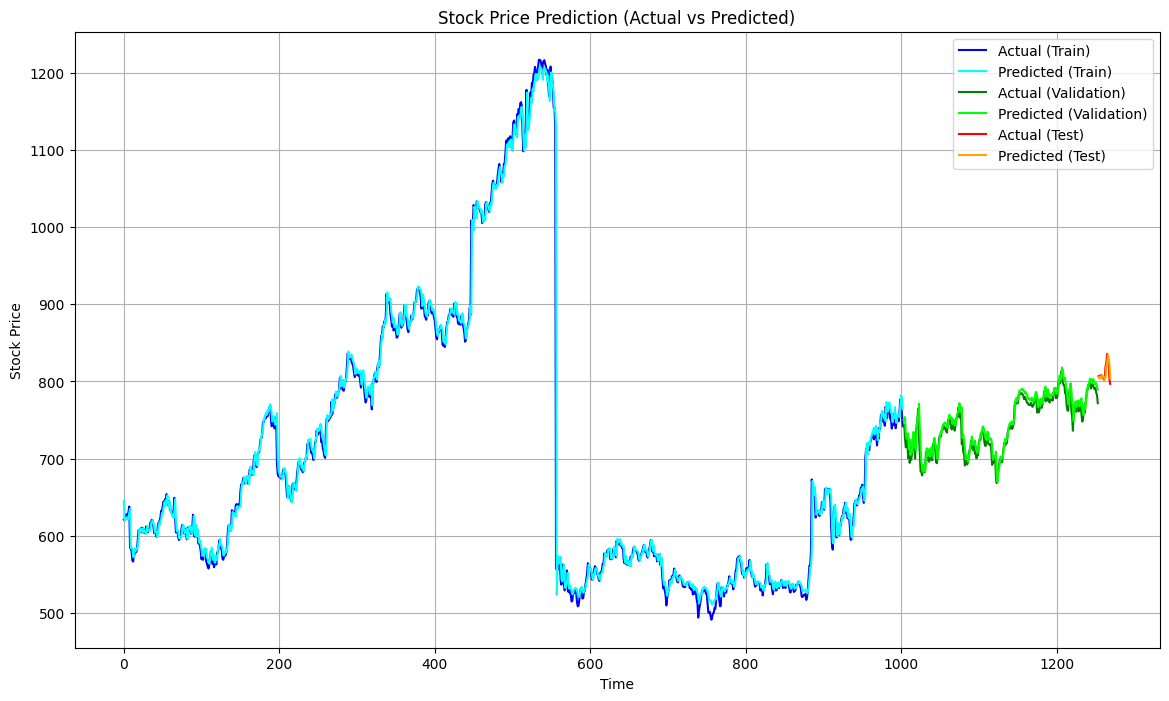

In [ ]:
y_train_pred = rnn_final_model.predict(X_train_final)
y_val_pred = rnn_final_model.predict(X_val)
y_test_pred = rnn_final_model.predict(X_test)

# Rescale values
def rescale_data(normalized_data, data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]

y_train_actual_rescaled = rescale_data(y_train_final, train_data[['Close']])
y_val_actual_rescaled = rescale_data(y_val, train_data[['Close']])
y_test_actual_rescaled = rescale_data(y_test, test_data[['Close']])

y_train_pred_rescaled = rescale_data(y_train_pred, train_data[['Close']])
y_val_pred_rescaled = rescale_data(y_val_pred, train_data[['Close']])
y_test_pred_rescaled = rescale_data(y_test_pred, test_data[['Close']])

# Plot the actual vs predicted values
plt.figure(figsize=(14, 8))
plt.plot(y_train_actual_rescaled, label='Actual (Train)', color='blue')
plt.plot(y_train_pred_rescaled, label='Predicted (Train)', color='cyan')
plt.plot(np.arange(len(y_train_actual_rescaled), len(y_train_actual_rescaled) + len(y_val_actual_rescaled)),
         y_val_actual_rescaled, label='Actual (Validation)', color='green')
plt.plot(np.arange(len(y_train_pred_rescaled), len(y_train_pred_rescaled) + len(y_val_pred_rescaled)),
         y_val_pred_rescaled, label='Predicted (Validation)', color='lime')
plt.plot(np.arange(len(y_train_actual_rescaled) + len(y_val_actual_rescaled), 
                 len(y_train_actual_rescaled) + len(y_val_actual_rescaled) + len(y_test_actual_rescaled)),
         y_test_actual_rescaled, label='Actual (Test)', color='red')
plt.plot(np.arange(len(y_train_pred_rescaled) + len(y_val_pred_rescaled),
                 len(y_train_pred_rescaled) + len(y_val_pred_rescaled) + len(y_test_pred_rescaled)),
         y_test_pred_rescaled, label='Predicted (Test)', color='orange')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (Actual vs Predicted)')
plt.legend()
plt.grid(True)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\12902\AppData\Local\Temp\ipykernel_2932\1732129617.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]  # Only 'Close' column (index 3)
C:\Users\12902\AppData\Local\Temp\ipykernel_2932\1732129617.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]  # Only 'Close' column (index 3)
C:\Users\12902\AppData\Local\Temp\ipykernel_2932\1732129617.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

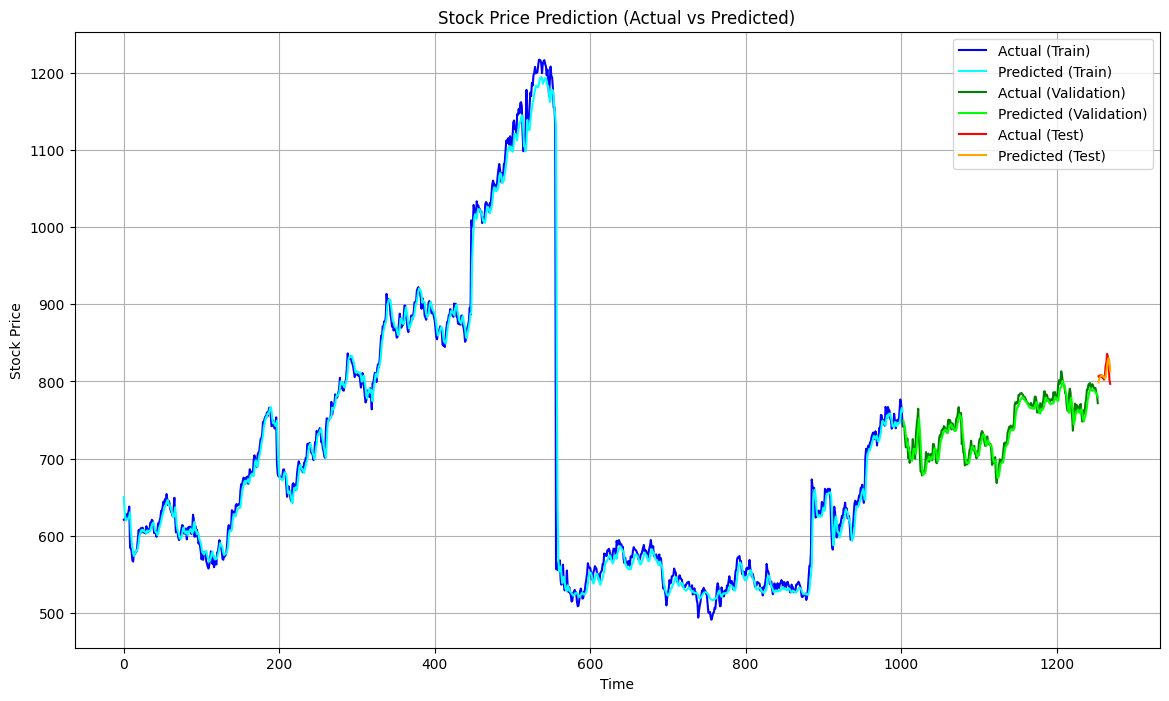

In [ ]:
y_train_pred = lstm_final_model.predict(X_train_final)
y_val_pred = lstm_final_model.predict(X_val)
y_test_pred = lstm_final_model.predict(X_test)

def rescale_data(normalized_data, data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]

y_train_actual_rescaled = rescale_data(y_train_final, train_data[['Close']])
y_val_actual_rescaled = rescale_data(y_val, train_data[['Close']])
y_test_actual_rescaled = rescale_data(y_test, test_data[['Close']])

y_train_pred_rescaled = rescale_data(y_train_pred, train_data[['Close']])
y_val_pred_rescaled = rescale_data(y_val_pred, train_data[['Close']])
y_test_pred_rescaled = rescale_data(y_test_pred, test_data[['Close']])

plt.figure(figsize=(14, 8))
plt.plot(y_train_actual_rescaled, label='Actual (Train)', color='blue')
plt.plot(y_train_pred_rescaled, label='Predicted (Train)', color='cyan')
plt.plot(np.arange(len(y_train_actual_rescaled), len(y_train_actual_rescaled) + len(y_val_actual_rescaled)),
         y_val_actual_rescaled, label='Actual (Validation)', color='green')
plt.plot(np.arange(len(y_train_pred_rescaled), len(y_train_pred_rescaled) + len(y_val_pred_rescaled)),
         y_val_pred_rescaled, label='Predicted (Validation)', color='lime')

plt.plot(np.arange(len(y_train_actual_rescaled) + len(y_val_actual_rescaled), 
                 len(y_train_actual_rescaled) + len(y_val_actual_rescaled) + len(y_test_actual_rescaled)),
         y_test_actual_rescaled, label='Actual (Test)', color='red')
plt.plot(np.arange(len(y_train_pred_rescaled) + len(y_val_pred_rescaled),
                 len(y_train_pred_rescaled) + len(y_val_pred_rescaled) + len(y_test_pred_rescaled)),
         y_test_pred_rescaled, label='Predicted (Test)', color='orange')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (Actual vs Predicted)')
plt.legend()
plt.grid(True)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


C:\Users\12902\AppData\Local\Temp\ipykernel_2932\1683880766.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]  # Only 'Close' column (index 3)
C:\Users\12902\AppData\Local\Temp\ipykernel_2932\1683880766.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]  # Only 'Close' column (index 3)
C:\Users\12902\AppData\Local\Temp\ipykernel_2932\1683880766.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

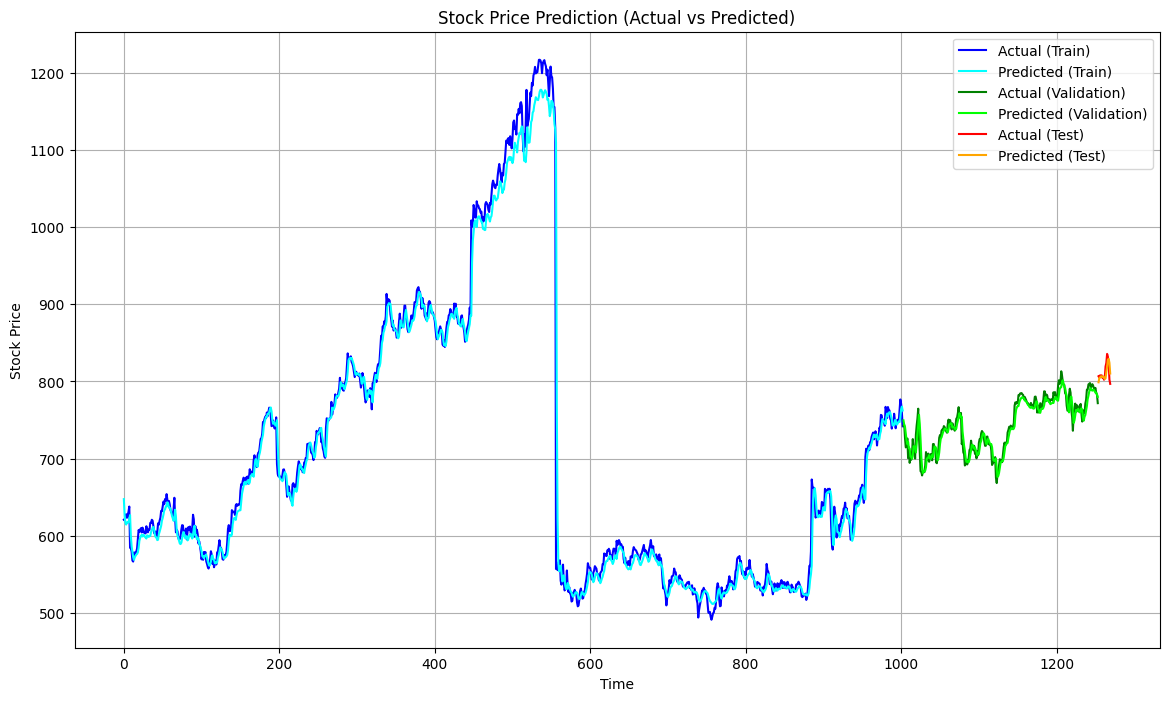

In [ ]:
y_train_pred = gru_final_model.predict(X_train_final)
y_val_pred = gru_final_model.predict(X_val)
y_test_pred = gru_final_model.predict(X_test)

def rescale_data(normalized_data, data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return normalized_data * (max_vals[0] - min_vals[0]) + min_vals[0]

y_train_actual_rescaled = rescale_data(y_train_final, train_data[['Close']])
y_val_actual_rescaled = rescale_data(y_val, train_data[['Close']])
y_test_actual_rescaled = rescale_data(y_test, test_data[['Close']])

y_train_pred_rescaled = rescale_data(y_train_pred, train_data[['Close']])
y_val_pred_rescaled = rescale_data(y_val_pred, train_data[['Close']])
y_test_pred_rescaled = rescale_data(y_test_pred, test_data[['Close']])

plt.figure(figsize=(14, 8))
plt.plot(y_train_actual_rescaled, label='Actual (Train)', color='blue')
plt.plot(y_train_pred_rescaled, label='Predicted (Train)', color='cyan')
plt.plot(np.arange(len(y_train_actual_rescaled), len(y_train_actual_rescaled) + len(y_val_actual_rescaled)),
         y_val_actual_rescaled, label='Actual (Validation)', color='green')
plt.plot(np.arange(len(y_train_pred_rescaled), len(y_train_pred_rescaled) + len(y_val_pred_rescaled)),
         y_val_pred_rescaled, label='Predicted (Validation)', color='lime')
plt.plot(np.arange(len(y_train_actual_rescaled) + len(y_val_actual_rescaled), 
                 len(y_train_actual_rescaled) + len(y_val_actual_rescaled) + len(y_test_actual_rescaled)),
         y_test_actual_rescaled, label='Actual (Test)', color='red')
plt.plot(np.arange(len(y_train_pred_rescaled) + len(y_val_pred_rescaled),
                 len(y_train_pred_rescaled) + len(y_val_pred_rescaled) + len(y_test_pred_rescaled)),
         y_test_pred_rescaled, label='Predicted (Test)', color='orange')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (Actual vs Predicted)')
plt.legend()
plt.grid(True)
plt.show()